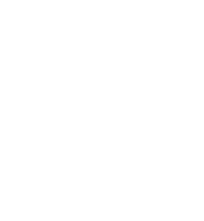

seed=1685895478


In [1]:
import algviz, random

# Define the topology structure.
nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges = [(4, 3), (0, 3), (6, 0), (2, 4), (5, 6), (1, 3), (7, 4), (8, 3), (9, 5), (7, 9), (9, 0), (1, 5), (7, 1), (8, 2), (6, 2), (1, 4), (6, 7), (0, 5)]
viz = algviz.Visualizer()
graph_nodes = algviz.parseGraph(nodes, edges, directed=False)
graph = viz.createGraph(graph_nodes, directed=False)
viz.display(0.1)

# Given the color number and create a initial solution.
COLORS = [algviz.color_orange, algviz.color_slate_blue, algviz.color_green]
COLOR_NUM = len(COLORS)
NODES_NUM = len(graph_nodes)

# Setup the random seed.
from random import seed
from time import time
rand_seed = 1685895478
seed(rand_seed)
print('seed={}'.format(rand_seed))

Graph:

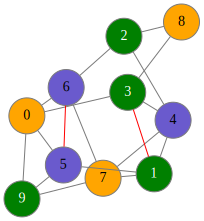

In [2]:
MAX_ITER_COUNT = 10

class LocalSolver:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        self.graph_nodes = algviz.parseGraph(nodes, edges, directed=False)
        self.viz = algviz.Visualizer(1)
        self.graph = self.viz.createGraph(self.graph_nodes, 'Graph', False)
        self.logger = self.viz.createLogger(1, show_line_num=False)
        self.viz.display()
        self.node_colors = []
        self.iter_count = 0
        for i in range(NODES_NUM):
            color = COLORS[random.randint(0, COLOR_NUM - 1)]
            self.node_colors.append(color)
        self.updateGraphDisplay()
        self.viz.display()

    def updateGraphDisplay(self):
        for i in range(NODES_NUM):
            self.graph.markNode(self.node_colors[i], self.graph_nodes[i])
        for (n1, n2) in self.edges:
            if self.node_colors[n1] == self.node_colors[n2]:
                self.graph.markEdge(algviz.color_red, self.graph_nodes[n1], self.graph_nodes[n2])

    def getConflictEdgeNum(self):
        res = 0
        for (n1, n2) in self.edges:
            if self.node_colors[n1] == self.node_colors[n2]:
                res += 1
        return res

    def updateSol(self, new_sol):
        for i in range(NODES_NUM):
            self.node_colors[i] = new_sol[i]
        self.updateGraphDisplay()
        self.viz.display()
    
    def pickMove(self):
        # Pick a color for a node to reduce the conflict edge number.
        best_delt = len(edges) + 1
        best_move = [None, None]
        cur_confilct_edge_num = self.getConflictEdgeNum()
        for n in range(NODES_NUM):
            for c in range(COLOR_NUM):
                old_node_color = self.node_colors[n]
                if COLORS[c] == old_node_color:
                    continue
                self.node_colors[n] = COLORS[c]
                delt = self.getConflictEdgeNum() - cur_confilct_edge_num
                self.node_colors[n] = old_node_color
                if delt < best_delt:
                    best_delt = delt
                    best_move = [n, COLORS[c]]
        return best_move, best_delt

    def applyMove(self, node, new_color, delt):
        # Assign a new color for the select node.
        self.node_colors[node] = new_color
        self.updateGraphDisplay()
        self.logger.write('Iter:{}, Delt:{}, Conflict edges:{}'.format(self.iter_count, delt, self.getConflictEdgeNum()))
        self.viz.display()

    def run(self):
        # Iterator util find a solution or steps limit.
        self.iter_count = 0
        while self.iter_count < MAX_ITER_COUNT:
            move, delt = self.pickMove()
            assert(move[0] != None)
            self.applyMove(move[0], move[1], delt)
            if (self.getConflictEdgeNum() == 0):
                break
            self.iter_count += 1

local_solver = LocalSolver(nodes, edges)
local_solver.run()

Graph:

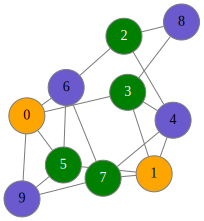

In [3]:
import math

MAX_ITER_COUNT = 20

class SimulatedAnnealing(LocalSolver):
    def __init__(self, nodes, edges):
        super().__init__(nodes, edges)
        self.noise = 6
        self.delt_noise = 0.3
        
    def pickMove(self):
        # Pick a color for a node to reduce the conflict edge number.
        best_delt = len(edges) + 1
        best_move = [None, None]
        cur_confilct_edge_num = self.getConflictEdgeNum()
        for n in range(NODES_NUM):
            for c in range(COLOR_NUM):
                old_node_color = self.node_colors[n]
                if COLORS[c] == old_node_color:
                    continue
                self.node_colors[n] = COLORS[c]
                delt = self.getConflictEdgeNum() - cur_confilct_edge_num
                self.node_colors[n] = old_node_color
                threshold = math.exp((-delt - 1)/self.noise)
                if delt < 0 or random.random() < threshold:
                    best_delt = delt
                    best_move = [n, COLORS[c]]
                if best_delt < 0:
                    break
        return best_move, best_delt

    def applyMove(self, node, new_color, delt):
        super().applyMove(node, new_color, delt)
        self.noise -= self.delt_noise

SA_solver = SimulatedAnnealing(nodes, edges)
SA_solver.updateSol(local_solver.node_colors)
SA_solver.applyMove(5, algviz.color_green, 1)
SA_solver.run()

In [ ]:
# Print the graph
print('p edge {} {}'.format(len(nodes), len(edges)))
for e in edges:
    print('e {} {}'.format(e[0] + 1, e[1] + 1))
print('nodes = {}'.format(nodes))
print('edges = {}'.format(edges))

In [ ]:
# Check solution.
sol = [0, 1, 2, 2, 0, 2, 1, 2, 1, 1]
class SolutionChecker(LocalSolver):
    def __init__(self, nodes, edges):
        super().__init__(nodes, edges)
    
    def check(self, sol):
        for n in range(len(sol)):
            self.node_colors[n] = COLORS[sol[n]]
        self.updateGraphDisplay()
        self.viz.display()
        print('Confilct edges:{}'.format(self.getConflictEdgeNum()))
SolutionChecker(nodes, edges).check(sol)